### Problem : There are users which are in same place at a specific time.
### So We will try to make clustering to identify their behaviours, most influential segment and how we can use this information for specific marketing needs using coexistince information from data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cosine
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### let's look at the data

In [8]:
df = pd.read_excel('Data.xlsx', sheet_name= 'data')
df.head()

,UserId_1,UserId_2
0,1753481,175348422
1,1753482,175348826
2,1753482,1753481047
3,1753483,175348209
4,1753483,175348612


In [9]:
len(df)

9076

### there are only two columns of UserId'S with 9076 rows
### So lets make them tuple and investigate about how many times they were together ?

In [10]:
arr = df[['UserId_1','UserId_2']].values

arr2 = arr.tolist()

for i in range(len(arr2)):
    if arr2[i][0]>arr2[i][1]:
        arr2[i] = arr2[i][::-1]
    
df['Pairs'] = tuple(arr2)
df = df.rename(columns={"UserId_1": "UserId1"})
df = df.rename(columns={"UserId_2": "UserId2"})

df.head()

,UserId1,UserId2,Pairs
0,1753481,175348422,"(1753481, 175348422)"
1,1753482,175348826,"(1753482, 175348826)"
2,1753482,1753481047,"(1753482, 1753481047)"
3,1753483,175348209,"(1753483, 175348209)"
4,1753483,175348612,"(1753483, 175348612)"


In [11]:
df_counts = df.groupby(['Pairs']).size().reset_index().rename(columns={0:'Cnts_of_Coexistance'})

df_counts.head()

,Pairs,Cnts_of_Coexistance
0,"(1753481, 175348422)",2
1,"(1753482, 175348826)",2
2,"(1753482, 1753481047)",2
3,"(1753483, 175348209)",2
4,"(1753483, 175348612)",2


In [12]:
np.max(df_counts.iloc[:,1])

2

In [13]:
len(df_counts)

4538

### all paired users were together only two times,So We cannnot get an information from here.
### but at the same time it allows us that make this new dataframe unique, because these counts mean that a user which in UserId1 is also in UserId2.So we can continue from this data frame

### lets seperate Pairs to columns and investigate about how many times the occurence is for unique users?

In [14]:
df_counts[['UserId1','UserId2']] = pd.DataFrame(df_counts['Pairs'].tolist())

df_counts.head()

,Pairs,Cnts_of_Coexistance,UserId1,UserId2
0,"(1753481, 175348422)",2,1753481,175348422
1,"(1753482, 175348826)",2,1753482,175348826
2,"(1753482, 1753481047)",2,1753482,1753481047
3,"(1753483, 175348209)",2,1753483,175348209
4,"(1753483, 175348612)",2,1753483,175348612


### Let's continue to count for each UserId1 from using last dataframe.Because if We use first dataframe and try to get the counts of each UserId, it gives equal counts for each UserId of columns.
### But with this last dataset, we can gather information about how many times a UserId uniquely occured.

In [15]:
dict_ID1_Cnts = {}
for value, count in df_counts["UserId1"].value_counts().items():
    dict_ID1_Cnts[value]=(value,count)

df_ID1_Counts = pd.DataFrame.from_dict(dict_ID1_Cnts,orient='index')
df_ID1_Counts = df_ID1_Counts.rename(columns={0: "UserId1", 1: "UserId1_Counts"})
    
dict_ID2_Cnts = {}
for value, count in df_counts["UserId2"].value_counts().items():
    dict_ID2_Cnts[value]=(value,count)
    
df_ID2_Counts = pd.DataFrame.from_dict(dict_ID2_Cnts,orient='index')
df_ID2_Counts = df_ID2_Counts.rename(columns={0: "UserId2", 1: "UserId2_Counts"})

In [16]:
len(df_ID1_Counts)

1544

In [17]:
len(df_ID2_Counts)

2322

In [18]:
df_ID1_Counts.head()

,UserId1,UserId1_Counts
175348298,175348298,53
175348304,175348304,44
175348389,175348389,41
175348205,175348205,41
17534893,17534893,39


In [19]:
df_ID2_Counts.head()

,UserId2,UserId2_Counts
1753482102,1753482102,20
175348841,175348841,16
1753482739,1753482739,15
175348736,175348736,14
1753481578,1753481578,14


### now lets merge them into our df_count dataframe and see results

In [20]:
df_counts2 = pd.merge(df_counts, df_ID1_Counts, on='UserId1', how='left')
df_counts2 = pd.merge(df_counts2, df_ID2_Counts, on='UserId2', how='left')
df_counts2.head(10)

,Pairs,Cnts_of_Coexistance,UserId1,UserId2,UserId1_Counts,UserId2_Counts
0,"(1753481, 175348422)",2,1753481,175348422,1,8
1,"(1753482, 175348826)",2,1753482,175348826,2,1
2,"(1753482, 1753481047)",2,1753482,1753481047,2,2
3,"(1753483, 175348209)",2,1753483,175348209,3,2
4,"(1753483, 175348612)",2,1753483,175348612,3,1
5,"(1753483, 175348749)",2,1753483,175348749,3,1
6,"(1753484, 175348124)",2,1753484,175348124,3,6
7,"(1753484, 175348543)",2,1753484,175348543,3,4
8,"(1753484, 1753482102)",2,1753484,1753482102,3,20
9,"(1753485, 1753486)",2,1753485,1753486,12,1


### so we have each userid's unique occuring counts now.
### We can use this information for clustering.

### let's check any nulls.

In [21]:
df_counts2.isnull().values.any()

False

### In Clustering or Recommendation, all the logic is in back of calculating distances.
### For example We can directly compute cosine similarity between each row and use this values for clustering
### or we can directly use unsupervised k-means algorithm which uses Euclidean distance to compute distances.
### For now let's try k-means algorithm

### Firstly lets look at the data distribution with newly created counts

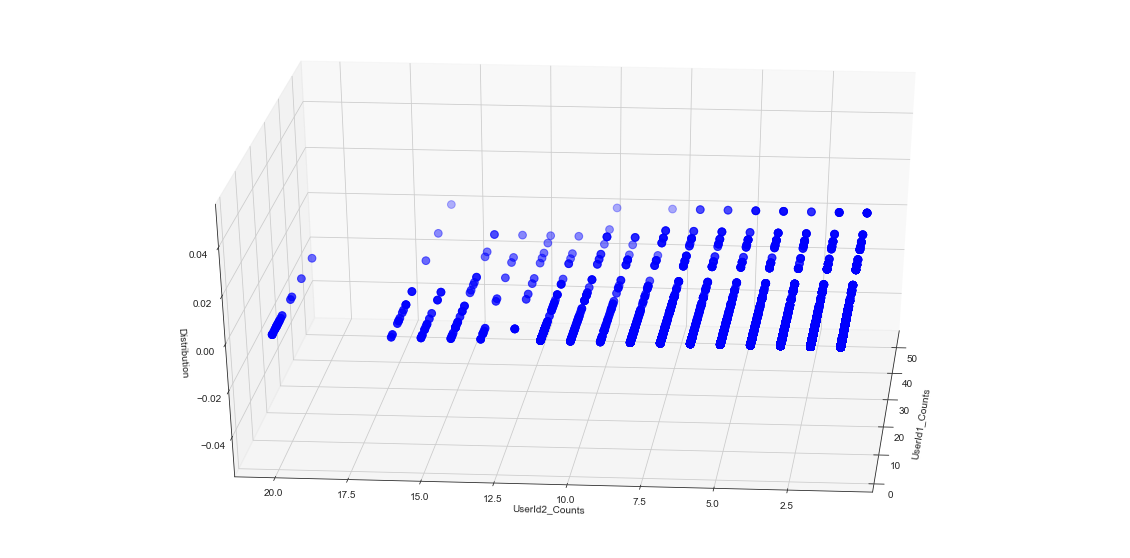

In [22]:
sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_counts2["UserId1_Counts"], df_counts2["UserId2_Counts"], c='blue', s=60)
ax.view_init(30, 185)
plt.xlabel("UserId1_Counts")
plt.ylabel("UserId2_Counts")
ax.set_zlabel('Distribution')
plt.show()

### let's find how many clusters we will choose

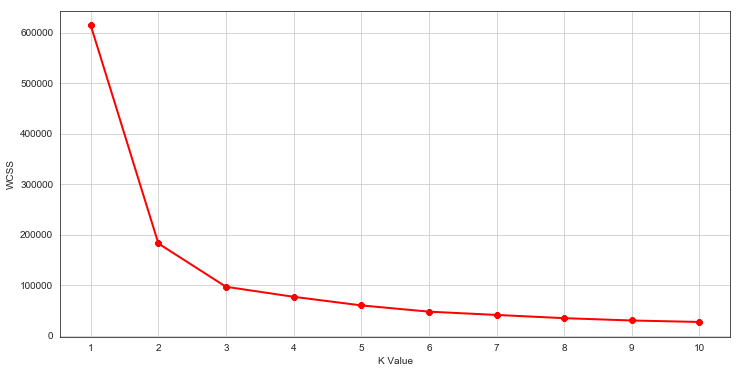

In [23]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_counts2.iloc[:,4:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

### it seems 2 or 3 clusters are enough for our data

### the graph also says 2 is enough but for researching aim, lets start with 3 clusters.

### let's make clustering now.

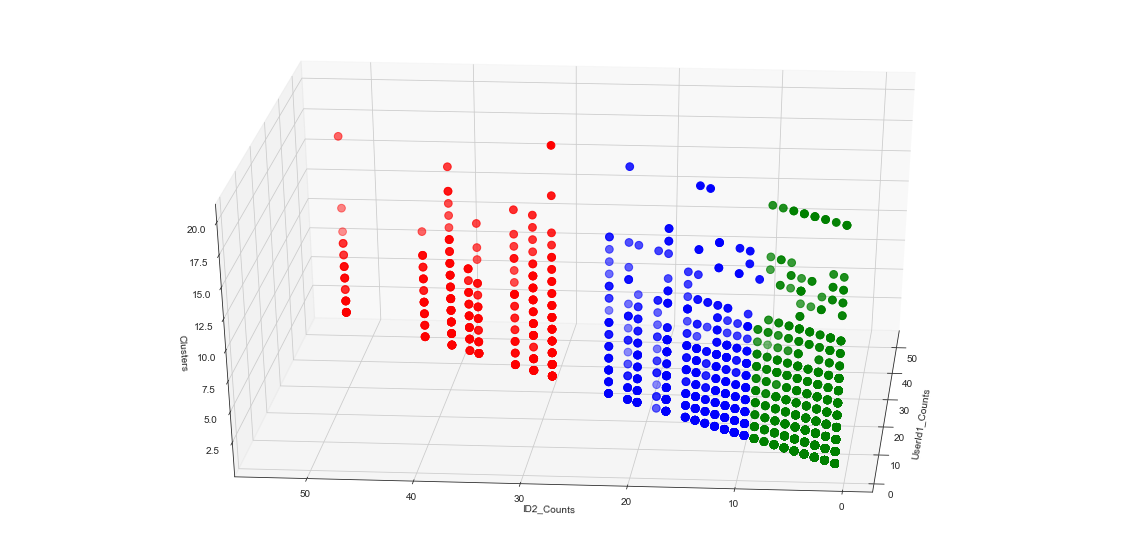

In [24]:
from sklearn import metrics
km = KMeans(n_clusters=3)
clusters = km.fit_predict(df_counts2.iloc[:,4:])
centers = km.cluster_centers_
df_counts2["Cluster"] = clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_counts2["UserId1_Counts"][df_counts2.Cluster == 0], df_counts2["UserId1_Counts"][df_counts2.Cluster == 0], df_counts2["UserId2_Counts"][df_counts2.Cluster == 0], c='blue', s=60)
ax.scatter(df_counts2["UserId1_Counts"][df_counts2.Cluster == 1], df_counts2["UserId1_Counts"][df_counts2.Cluster == 1], df_counts2["UserId2_Counts"][df_counts2.Cluster == 1], c='red', s=60)
ax.scatter(df_counts2["UserId1_Counts"][df_counts2.Cluster == 2], df_counts2["UserId1_Counts"][df_counts2.Cluster == 2], df_counts2["UserId2_Counts"][df_counts2.Cluster == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("UserId1_Counts")
plt.ylabel("ID2_Counts")
ax.set_zlabel('Clusters')
plt.show()

### now we have 3  clusters.
### let's investigate how good they are seperated from each other using Silhouette Score.

In [25]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_counts2.iloc[:,4:], clusters)
df_counts2['Sample_Silhouette_Values'] = sample_silhouette_values
df_counts2.groupby(['Cluster']).mean()['Sample_Silhouette_Values']

Cluster
0   0.429
1   0.566
2   0.669
Name: Sample_Silhouette_Values, dtype: float64

### with 3 clusters' , we can say that Cluster 2 (green) is the most well-seperated cluster,
### after that cluster 1 (red) is the second well-seperated cluster
### and the cluster 0 (blue) is the worst one regard to silhouette scores.

### Cluster 0 and 2 should be combined which is indicated in elbow graph.

In [26]:
df_counts2.head()

,Pairs,Cnts_of_Coexistance,UserId1,UserId2,UserId1_Counts,UserId2_Counts,Cluster,Sample_Silhouette_Values
0,"(1753481, 175348422)",2,1753481,175348422,1,8,2,0.606
1,"(1753482, 175348826)",2,1753482,175348826,2,1,2,0.764
2,"(1753482, 1753481047)",2,1753482,1753481047,2,2,2,0.784
3,"(1753483, 175348209)",2,1753483,175348209,3,2,2,0.780
4,"(1753483, 175348612)",2,1753483,175348612,3,1,2,0.758


### let's compute also cluster centers.

In [27]:
cluster_centers = []
for i in range(len(centers)):
    cluster_centers.append(np.sum(centers[i],axis=0) / len(centers))
    
cluster_centers

[6.5673680324843025, 14.189189189189134, 2.2223963229917385]

### as it can be interpreted from cluster centers, the most well-seperated cluster 2(green) includes low-number occuring users.
### and second well-seperated cluster 1(red) includes high-number occuring people.

## *

### Now make clustering again with 2 clusters and check the results.

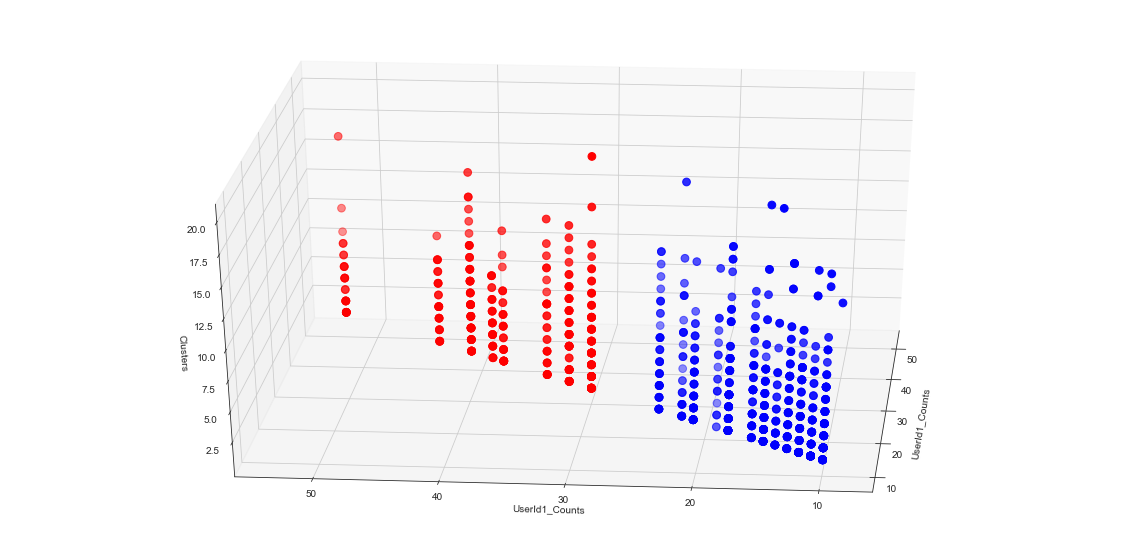

In [28]:
from sklearn import metrics
km2 = KMeans(n_clusters=2)
clusters2 = km2.fit_predict(df_counts2.iloc[:,4:6])
centers2 = km2.cluster_centers_
df_counts2["Cluster_2"] = clusters2
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_counts2["UserId1_Counts"][df_counts2.Cluster == 0], df_counts2["UserId1_Counts"][df_counts2.Cluster == 0], df_counts2["UserId2_Counts"][df_counts2.Cluster == 0], c='blue', s=60)
ax.scatter(df_counts2["UserId1_Counts"][df_counts2.Cluster == 1], df_counts2["UserId1_Counts"][df_counts2.Cluster == 1], df_counts2["UserId2_Counts"][df_counts2.Cluster == 1], c='red', s=60)
#ax.scatter(df_counts2["ID1_Counts"][df_counts2.Cluster == 2], df_counts2["ID1_Counts"][df_counts2.Cluster == 2], df_counts2["ID2_Counts"][df_counts2.Cluster == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("UserId1_Counts")
plt.ylabel("UserId1_Counts")
ax.set_zlabel('Clusters')
plt.show()

### compute silhouette scores again.

In [29]:
# Compute the silhouette scores for each sample
sample_silhouette_values_2 = silhouette_samples(df_counts2.iloc[:,4:6], clusters2)
df_counts2['Sample_Silhouette_Values_2C'] = sample_silhouette_values_2
df_counts2.groupby(['Cluster_2']).mean()['Sample_Silhouette_Values_2C']

Cluster_2
0   0.755
1   0.529
Name: Sample_Silhouette_Values_2C, dtype: float64

### now we have more well-seperated 2 clusters from each other. 

In [30]:
df_counts2.head()

,Pairs,Cnts_of_Coexistance,UserId1,UserId2,UserId1_Counts,UserId2_Counts,Cluster,Sample_Silhouette_Values,Cluster_2,Sample_Silhouette_Values_2C
0,"(1753481, 175348422)",2,1753481,175348422,1,8,2,0.606,0,0.768
1,"(1753482, 175348826)",2,1753482,175348826,2,1,2,0.764,0,0.839
2,"(1753482, 1753481047)",2,1753482,1753481047,2,2,2,0.784,0,0.848
3,"(1753483, 175348209)",2,1753483,175348209,3,2,2,0.780,0,0.853
4,"(1753483, 175348612)",2,1753483,175348612,3,1,2,0.758,0,0.844


### lets compute cluster centers again.

In [31]:
cluster_centers2 = []
for i in range(len(centers2)):
    cluster_centers2.append(np.sum(centers2[i],axis=0) / len(centers2))
    
cluster_centers2

[4.338042640636974, 18.751937984496028]

### now we have more clarified clusters which are best well-seperated cluster 0(blue) includes low-number occuring users
### and cluster 1 (red) which includes high-number occuring users.

# **

### Let's investigate more in depth of data.
### Let's turn to our first dataframe and compute all coexistence counts for each UserId for each column and check the results again.
### If there will be a improvement, may be these values can be used for segmentation.

In [33]:
dict_ID1 = {}
for value, count in df["UserId1"].value_counts().items():
    dict_ID1[value]=(value,count)

df_ID1_Cnts = pd.DataFrame.from_dict(dict_ID1,orient='index')
df_ID1_Cnts = df_ID1_Cnts.rename(columns={0: "UserId1", 1: "UserId1_Counts"})
    
dict_ID2 = {}
for value, count in df["UserId2"].value_counts().items():
    dict_ID2[value]=(value,count)
    
df_ID2_Cnts = pd.DataFrame.from_dict(dict_ID2,orient='index')
df_ID2_Cnts = df_ID2_Cnts.rename(columns={0: "UserId2", 1: "UserId2_Counts"})


df_new_with_base_counts = pd.merge(df, df_ID1_Cnts, on='UserId1', how='left')
df_new_with_base_counts_2 = pd.merge(df_new_with_base_counts, df_ID2_Cnts, on='UserId2', how='left')
df_new_with_base_counts_2.head(10)

,UserId1,UserId2,Pairs,UserId1_Counts,UserId2_Counts
0,1753481,175348422,"(1753481, 175348422)",1,27
1,1753482,175348826,"(1753482, 175348826)",2,1
2,1753482,1753481047,"(1753482, 1753481047)",2,2
3,1753483,175348209,"(1753483, 175348209)",3,7
4,1753483,175348612,"(1753483, 175348612)",3,1
5,1753483,175348749,"(1753483, 175348749)",3,2
6,1753484,175348124,"(1753484, 175348124)",3,28
7,1753484,175348543,"(1753484, 175348543)",3,7
8,1753484,1753482102,"(1753484, 1753482102)",3,20
9,1753485,1753486,"(1753485, 1753486)",12,16


In [34]:
len(df_new_with_base_counts_2)

9076

### lets find again how many clusters to choose.

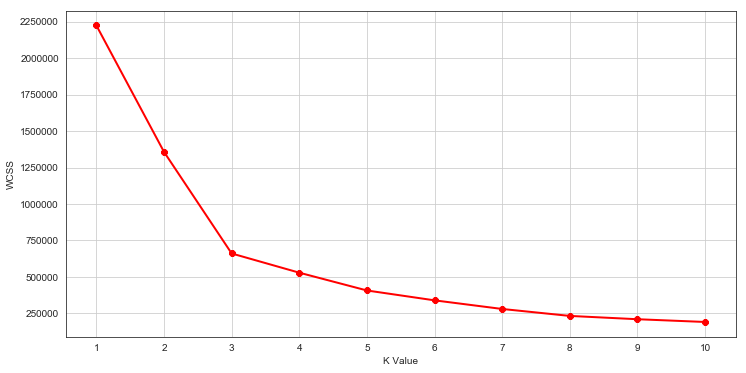

In [35]:
from sklearn.cluster import KMeans
wcss2 = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_new_with_base_counts_2.iloc[:,3:])
    wcss2.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss2, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

### the graph says 3 clusters we should make.

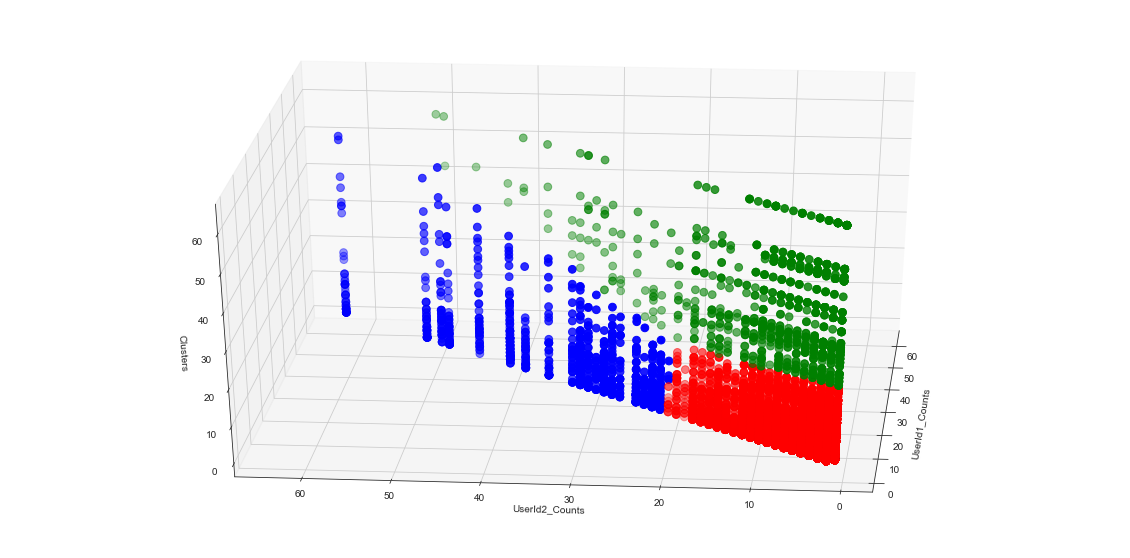

In [36]:
from sklearn import metrics
km3 = KMeans(n_clusters=3)
clusters3 = km3.fit_predict(df_new_with_base_counts_2.iloc[:,3:])
centers3 = km3.cluster_centers_
df_new_with_base_counts_2["Cluster"] = clusters3
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new_with_base_counts_2["UserId1_Counts"][df_new_with_base_counts_2.Cluster == 0], df_new_with_base_counts_2["UserId1_Counts"][df_new_with_base_counts_2.Cluster == 0], df_new_with_base_counts_2["UserId2_Counts"][df_new_with_base_counts_2.Cluster == 0], c='blue', s=60)
ax.scatter(df_new_with_base_counts_2["UserId1_Counts"][df_new_with_base_counts_2.Cluster == 1], df_new_with_base_counts_2["UserId1_Counts"][df_new_with_base_counts_2.Cluster == 1], df_new_with_base_counts_2["UserId2_Counts"][df_new_with_base_counts_2.Cluster == 1], c='red', s=60)
ax.scatter(df_new_with_base_counts_2["UserId1_Counts"][df_new_with_base_counts_2.Cluster == 2], df_new_with_base_counts_2["UserId1_Counts"][df_new_with_base_counts_2.Cluster == 2], df_new_with_base_counts_2["UserId2_Counts"][df_new_with_base_counts_2.Cluster == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("UserId1_Counts")
plt.ylabel("UserId2_Counts")
ax.set_zlabel('Clusters')
plt.show()

### now check silhouette score.

In [37]:
# Compute the silhouette scores for each sample
sample_silhouette_values3 = silhouette_samples(df_new_with_base_counts_2.iloc[:,3:], clusters3)
df_new_with_base_counts_2['Sample_Silhouette_Values'] = sample_silhouette_values3
df_new_with_base_counts_2.groupby(['Cluster']).mean()['Sample_Silhouette_Values']

Cluster
0   0.433
1   0.725
2   0.431
Name: Sample_Silhouette_Values, dtype: float64

### calculate cluster centers.

In [38]:
cluster_centers3 = []
for i in range(len(centers3)):
    cluster_centers3.append(np.sum(centers3[i],axis=0) / len(centers3))
    
cluster_centers3

[15.078061413244532, 3.7187385405206883, 15.087486157253574]

### interpretation of the clustering with base data:
### even cluster 1 is the best well-best seperated cluster(red) which includes low-number occuring userids,the other two clusters didnt seperated from each other very well,The both of them includes same high-number occuring userids

### So We should use the last clustering (with 2) which is done lastly before this work-research and make interpretations.

### Please check the results which done between single and double-star markdown..(2 clusters).

# ***

# So :

## 1-) : We Identified 2 Clusters for users based on coexistance.

## 2-) : Most well-seperated cluster included low-number occuring usersid with mean(4.33),(Cluster 0) and the Second Cluster includes high-number occuring people with mean(18.75),(Cluster 1).Cluster 1 is the most influential segment for marketing from this aspect.

## 3-) : By clustering, We made segmentation for our users which seperated as Low-Number and High-Number occured users.We can give extra advantageous rights to our high-number occuring users because they are more valuable from marketing aspect.

## 4-) : From the aspect of marketing for low occuring users , as seen below, We can take Cluster 0 (low-number occuring users) with low Silhouette Scores which points at they are more close to people who are in high value segment. 

In [39]:
df_counts2.head()

,Pairs,Cnts_of_Coexistance,UserId1,UserId2,UserId1_Counts,UserId2_Counts,Cluster,Sample_Silhouette_Values,Cluster_2,Sample_Silhouette_Values_2C
0,"(1753481, 175348422)",2,1753481,175348422,1,8,2,0.606,0,0.768
1,"(1753482, 175348826)",2,1753482,175348826,2,1,2,0.764,0,0.839
2,"(1753482, 1753481047)",2,1753482,1753481047,2,2,2,0.784,0,0.848
3,"(1753483, 175348209)",2,1753483,175348209,3,2,2,0.780,0,0.853
4,"(1753483, 175348612)",2,1753483,175348612,3,1,2,0.758,0,0.844


In [40]:
df_counts2.loc[(df_counts2['Cluster_2'] == 0) &  (df_counts2['Sample_Silhouette_Values_2C'] <= 0.15)]

,Pairs,Cnts_of_Coexistance,UserId1,UserId2,UserId1_Counts,UserId2_Counts,Cluster,Sample_Silhouette_Values,Cluster_2,Sample_Silhouette_Values_2C
57,"(1753488, 175348574)",2,1753488,175348574,18,8,0,0.564,0,0.149
144,"(17534822, 175348422)",2,17534822,175348422,18,8,0,0.564,0,0.149
145,"(17534822, 175348561)",2,17534822,175348561,18,11,0,0.475,0,0.130
146,"(17534822, 175348833)",2,17534822,175348833,18,12,0,0.445,0,0.123
150,"(17534822, 1753481578)",2,17534822,1753481578,18,14,0,0.387,0,0.110
151,"(17534822, 1753481597)",2,17534822,1753481597,18,10,0,0.506,0,0.137
154,"(17534822, 1753482265)",2,17534822,1753482265,18,10,0,0.506,0,0.137
669,"(175348140, 175348561)",2,175348140,175348561,18,11,0,0.475,0,0.130
673,"(175348140, 175348841)",2,175348140,175348841,18,16,0,0.336,0,0.097
683,"(175348140, 1753482739)",2,175348140,1753482739,18,15,0,0.361,0,0.104


# Thanks

# Hincal Topcuoglu

# ****